### As the first step all neccessary libraries will be imported; this list will be updated as we are going forward

In [1955]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn import ensemble
import seaborn as sns
import numpy as np
from collections import Counter

In [1956]:
trData = pd.read_csv('train.csv')
testData = pd.read_csv('test.csv')
data_list = [trData, testData]
trData.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Cleaning
## The columns which are not numeric will be converted to numeric and the columns with too many NaNs will be removed (e.g., the Cabin)

In [1957]:
print("Total number of samples in train set is:", len(trData))
print("-"*45)
print("The number of null (NaN) values in each column of the train set is:")
print(trData.isnull().sum())
print("*"*70)
print("Total number of samples in test set is:", len(testData))
print("-"*45)
print("The number of null (NaN) values in each column of the train set is:")
print(testData.isnull().sum())

Total number of samples in train set is: 891
---------------------------------------------
The number of null (NaN) values in each column of the train set is:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
**********************************************************************
Total number of samples in test set is: 418
---------------------------------------------
The number of null (NaN) values in each column of the train set is:
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [1958]:
for data in data_list:
    #data['Age'].fillna(trData['Age'].median(), inplace = True)
    data['Embarked'].fillna(trData['Embarked'].mode()[0], inplace = True)

In [1959]:
print("Total number of samples in train set is:", len(trData))
print("-"*45)
print("The number of null (NaN) values in each column of the train set is:")
print(trData.isnull().sum())
print("*"*70)
print("Total number of samples in test set is:", len(testData))
print("-"*45)
print("The number of null (NaN) values in each column of the train set is:")
print(testData.isnull().sum())

Total number of samples in train set is: 891
---------------------------------------------
The number of null (NaN) values in each column of the train set is:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64
**********************************************************************
Total number of samples in test set is: 418
---------------------------------------------
The number of null (NaN) values in each column of the train set is:
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [1963]:
combinedData = pd.concat(objs=[trData, testData], axis=0).reset_index(drop=True)

In [1964]:
PclassVsFare = combinedData[['Pclass','Fare']].groupby(['Pclass'], as_index = False).mean()
PclassVsFare

,Pclass,Fare
0,1,87.508992
1,2,21.179196
2,3,13.302889


In [1965]:
testData['Pclass'][testData['Fare'].isnull()] 

152    3
Name: Pclass, dtype: int64

In [1966]:
# The passenger with missing class has a Pclass of 3 whose average Fare is 13.67 
testData['Fare'].fillna(PclassVsFare.loc[2,'Fare'], inplace = True);

In [1967]:
for data in data_list:
    data['Title'] = data['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
testData.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,Mr
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,Mrs
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,Mr
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,Mr
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,Mrs


In [1968]:
testData['Title'].value_counts()

Mr        240
Miss       78
Mrs        72
Master     21
Rev         2
Col         2
Dona        1
Dr          1
Ms          1
Name: Title, dtype: int64

In [1969]:
trData['Title'].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Major             2
Col               2
Mlle              2
Mme               1
the Countess      1
Ms                1
Jonkheer          1
Sir               1
Don               1
Lady              1
Capt              1
Name: Title, dtype: int64

In [1970]:
for data in data_list:
    data['Title'] = data['Title'].replace(['Lady', 'Sir', 'the Countess'], 'Royal')
    data['Title'] = data['Title'].replace(['Ms', 'Mlle'], 'Miss')
    data['Title'] = data['Title'].replace('Mme', 'Mrs')
    data['Title'] = data['Title'].replace(['Lady', 'Capt', 'Col',
    'Don', 'Dr', 'Major', 'Rev', 'Jonkheer', 'Dona'], 'Rare')

In [1971]:
trData['Title'].value_counts()

Mr        517
Miss      185
Mrs       126
Master     40
Rare       20
Royal       3
Name: Title, dtype: int64

In [1972]:
testData['Title'].value_counts()

Mr        240
Miss       79
Mrs        72
Master     21
Rare        6
Name: Title, dtype: int64

In [1973]:
#min_val = 10
#title_names = (trData['Title'].value_counts() < min_val)
#trData['Title'] = trData['Title'].apply(lambda x: 'Misc' if title_names.loc[x] == True else x)

In [1974]:
combinedData = pd.concat(objs=[trData, testData], axis=0).reset_index(drop=True)

In [1975]:
title_vs_age = combinedData[['Title', 'Age']].groupby(['Title'], as_index = False).mean()
title_vs_age

,Title,Age
0,Master,5.482642
1,Miss,21.824366
2,Mr,32.252151
3,Mrs,36.918129
4,Rare,45.400000
5,Royal,43.333333


In [1976]:
title_vs_age.loc[title_vs_age['Title'] == 'Master', 'Age'][0]

5.4826415094339627

In [1977]:
for i in range(0, len(title_vs_age)):
    title_temp = title_vs_age.loc[i]['Title']
    trData.loc[trData['Age'].isnull() & (trData['Title'] == title_temp), 'Age'] = title_vs_age.loc[title_vs_age['Title'] == title_temp, 'Age'][i]
    testData.loc[testData['Age'].isnull() & (testData['Title'] == title_temp), 'Age'] = title_vs_age.loc[title_vs_age['Title'] == title_temp, 'Age'][i]

### Cabin code; missing cabin code is converted to 0, and existing ones converted to 1

In [1978]:
for data in data_list:
    data['CabinCode'] = (data['Cabin'].notnull()) * 1

## Transfer categorial values to discrete values

In [1979]:
trData.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,CabinCode
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,0


In [1980]:
trData['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Rare', 'Royal'], dtype=object)

### Define the age bins and fare bins

In [1981]:
age_bins = [0, 12, 19, 31, 35, 60, np.inf]
age_labels = ['Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
trData['AgeGroup'] = pd.cut(trData["Age"], age_bins, labels = age_labels)
testData['AgeGroup'] = pd.cut(testData["Age"], age_bins, labels = age_labels)

In [1982]:
trData['AgeGroup'].value_counts()

Student        300
Adult          213
Young Adult    188
Teenager        95
Child           73
Senior          22
Name: AgeGroup, dtype: int64

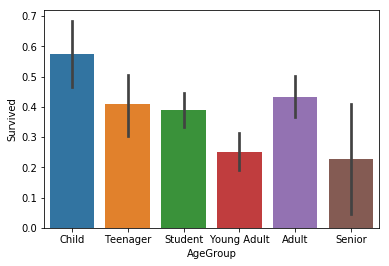

In [1983]:
sns.barplot(x = 'AgeGroup', y = 'Survived', data = trData)
plt.show()

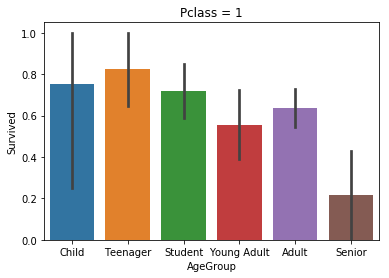

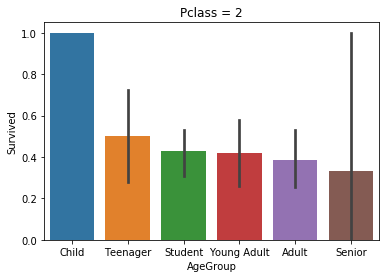

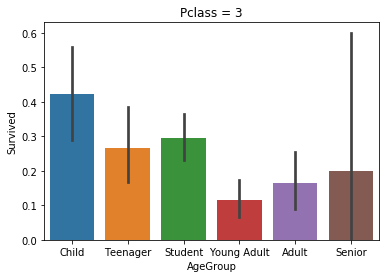

In [1984]:
g = sns.barplot(x = 'AgeGroup', y = 'Survived', data = trData.loc[trData['Pclass'] == 1])
g.set_title("Pclass = 1")
plt.show()
g = sns.barplot(x = 'AgeGroup', y = 'Survived', data = trData.loc[trData['Pclass'] == 2])
g.set_title("Pclass = 2")
plt.show()
g = sns.barplot(x = 'AgeGroup', y = 'Survived', data = trData.loc[trData['Pclass'] == 3])
g.set_title("Pclass = 3")
plt.show()

In [1985]:
trData['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [1986]:
pd.qcut(trData['Fare'], 3).value_counts()

(-0.001, 8.662]    308
(26.0, 512.329]    295
(8.662, 26.0]      288
Name: Fare, dtype: int64

In [1987]:
combinedData[['Pclass','Fare']].groupby(['Pclass'], as_index = False).median()

,Pclass,Fare
0,1,60.0000
1,2,15.0458
2,3,8.0500


In [1988]:
trData['Fare'].describe()
fare_bins = [-0.1,  7.5, 15, 40, 70, np.inf]
fare_labels = ['Cheap', 'BelowAverage', 'Average', 'AboveAverage','Expensive']
trData['FareBin'] = pd.cut(trData['Fare'], fare_bins, labels = fare_labels)
testData['FareBin'] = pd.cut(testData['Fare'], fare_bins, labels = fare_labels)

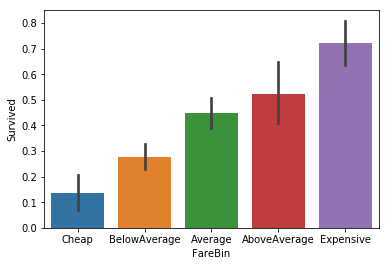

In [1989]:
sns.barplot(x = 'FareBin', y = 'Survived', data = trData)
plt.show()

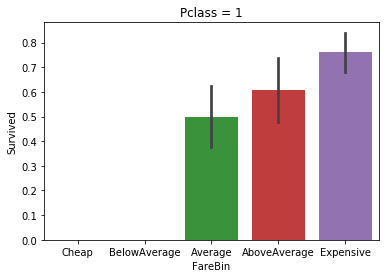

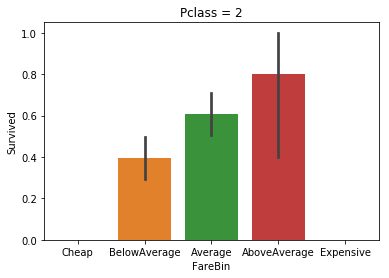

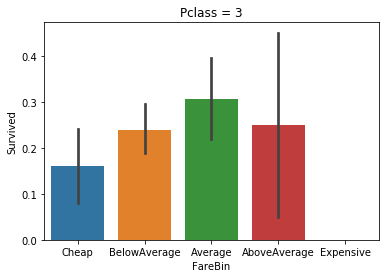

In [1990]:
g = sns.barplot(x = 'FareBin', y = 'Survived', data = trData.loc[trData['Pclass'] == 1])
g.set_title("Pclass = 1")
plt.show()
g = sns.barplot(x = 'FareBin', y = 'Survived', data = trData.loc[trData['Pclass'] == 2])
g.set_title("Pclass = 2")
plt.show()
g = sns.barplot(x = 'FareBin', y = 'Survived', data = trData.loc[trData['Pclass'] == 3])
g.set_title("Pclass = 3")
plt.show()

In [1991]:
trData['FareBin'].value_counts()

BelowAverage    371
Average         257
Expensive       105
Cheap            87
AboveAverage     71
Name: FareBin, dtype: int64

In [1992]:
for data in data_list:
    #data['FareBinCode'] = label.fit_transform(data['FareBin'])
    #data['AgeBinCode'] = label.fit_transform(data['AgeBin']) 
    data['SexCode'] = data['Sex'].replace(['female', 'male'], [0, 1])
    data['EmbarkedCode'] = data['Embarked'].replace(['S', 'Q', 'C'], [0, 1, 2])
    data['TitleCode'] = data['Title'].replace(['Mr', 'Mrs', 'Miss', 'Master','Royal', 'Rare'], [0, 1, 2, 3, 4, 5])
    data['Nfamily'] = data['Parch'] + data['SibSp']
    data['IsAlone'] = 1
    data.loc[data['Nfamily'] > 0, 'IsAlone'] = 0
    data['AgeGroup'] = data['AgeGroup'].replace(age_labels,[0, 1, 2, 3, 4, 5])
    data['FareBin'] = data['FareBin'].replace(fare_labels, [0, 1, 2, 3, 4])

In [1993]:
testData.isnull().sum()

PassengerId       0
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin           327
Embarked          0
Title             0
CabinCode         0
AgeGroup          0
FareBin           0
SexCode           0
EmbarkedCode      0
TitleCode         0
Nfamily           0
IsAlone           0
dtype: int64

# Statistical Analysis and feature engineering

In [1994]:
trData[['Nfamily', 'Survived']].groupby(['Nfamily'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Nfamily,Survived
3,3,0.724138
2,2,0.578431
1,1,0.552795
6,6,0.333333
0,0,0.303538
4,4,0.200000
5,5,0.136364
7,7,0.000000
8,10,0.000000


In [1995]:
trData[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


In [1996]:
trData[['Sex','Survived']].groupby(['Sex'], as_index = False).mean()

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [1997]:
trData[['SibSp','Survived']].groupby(['SibSp'], as_index = False).mean()

/home/srazavi/.local/lib/python3.4/site-packages/IPython/core/displayhook.py:271: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  'Flushing oldest {cull_count} entries.'.format(sz=sz, cull_count=cull_count))


,SibSp,Survived
0,0,0.345395
1,1,0.535885
2,2,0.464286
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [1998]:
trData['SibSp'].value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In [1999]:
trData[['Pclass','Fare','Survived']].groupby(['Pclass'], as_index = False).mean()

,Pclass,Fare,Survived
0,1,84.154687,0.629630
1,2,20.662183,0.472826
2,3,13.675550,0.242363


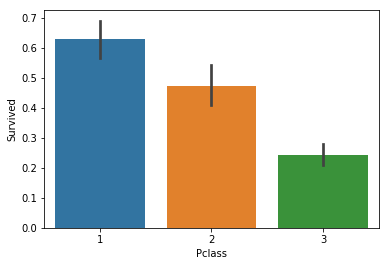

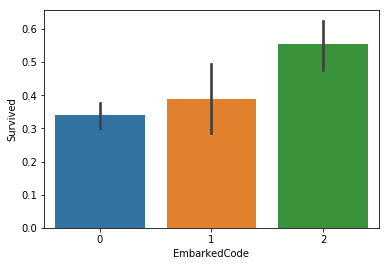

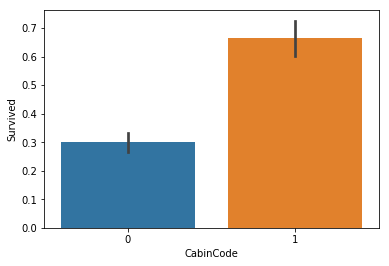

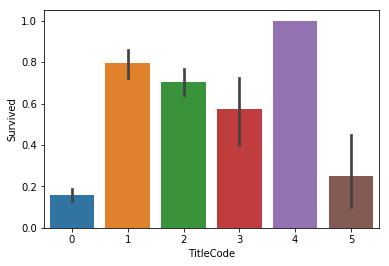

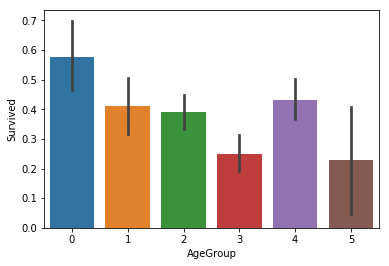

In [2000]:
sns.barplot(x="Pclass", y="Survived", data=trData)
plt.show()
sns.barplot(x="EmbarkedCode", y="Survived", data=trData)
plt.show()
sns.barplot(x = "CabinCode", y = "Survived", data = trData)
plt.show()
sns.barplot(x = "TitleCode", y = "Survived", data = trData)
plt.show()
sns.barplot(x = "AgeGroup", y = "Survived", data = trData)
plt.show()

In [2001]:
pd.crosstab(trData['Sex'], trData['Survived'])

Survived,0,1
Sex,,
female,81,233
male,468,109


In [2002]:
trData[['TitleCode','Survived']].groupby(['TitleCode'], as_index = False).mean()

,TitleCode,Survived
0,0,0.156673
1,1,0.793651
2,2,0.702703
3,3,0.575000
4,4,1.000000
5,5,0.250000


In [2003]:
age_kid = 16
print("Number of kids younger than {} is {}.".format(age_kid, (trData['Age'] < age_kid).sum()))
kids_survival_rate = trData['Survived'][trData['Age'] < age_kid].sum() / (trData['Age'] < age_kid).sum()
overal_survival_rate = trData['Survived'].sum() / len(trData['Survived'])
print("Survival rate of these kids is {} while the overal survival rate is {}.".format(round(kids_survival_rate, 2), round(overal_survival_rate, 2)))

Number of kids younger than 16 is 87.
Survival rate of these kids is 0.59 while the overal survival rate is 0.38.


In [2004]:
for data in data_list:
    data['IsChild'] = (data['Age'] < age_kid) * 1

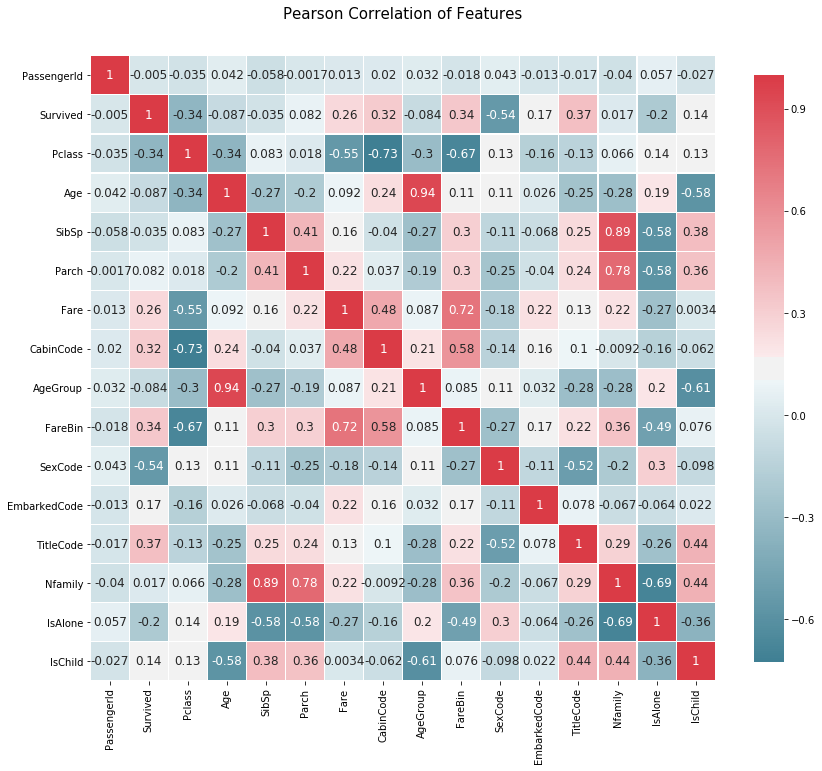

In [2005]:
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(trData)
plt.show()

# Classification models

In [2006]:
selectedFeatures = ['Pclass', 'SexCode', 'AgeGroup', 'TitleCode', 'Nfamily', 'IsAlone', 'EmbarkedCode', 'FareBin'
                   ];
X = trData[selectedFeatures]
y = trData['Survived']

In [2007]:
X.head()

,Pclass,SexCode,AgeGroup,TitleCode,Nfamily,IsAlone,EmbarkedCode,FareBin
0,3,1,2,0,1,0,0,0
1,1,0,4,1,1,0,2,4
2,3,0,2,2,0,1,0,1
3,1,0,3,1,1,0,0,3
4,3,1,3,0,0,1,0,1


In [2008]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0)

In [2009]:
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .7, random_state = 0) 
grid_bool = [True, False]
C_param_range = [0.001,0.01,0.1,0.2,1,10,11,12,13,20, 30, 40]
grid_ratio_list = [.1, .25, .5, .75, 1.0]
grid_n_neighbors = range(1, 20)
grid_n_estimator = [10, 50, 100, 300]
grid_learn = [.01, .03, .05, .1, .25]
grid_max_depth = [2, 4, 6, 8, 10, None]
grid_min_samples = [5, 10, .03, .05, .10]
grid_criterion = ['gini', 'entropy']
grid_bool = [True, False]
grid_seed = [0]

clf_list = [LogisticRegression(), SVC(), ensemble.GradientBoostingClassifier(), ensemble.RandomForestClassifier(), 
            ensemble.ExtraTreesClassifier(), KNeighborsClassifier()]
grid_param_list = [[{
            #LogisticRegressionCV - http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html#sklearn.linear_model.LogisticRegressionCV
            'fit_intercept': grid_bool, #default: True
            #'penalty': ['l1','l2'],
            'C': C_param_range,
            #'solver': ['newton-cg','lbfgs','liblinear']
             }],
             [{
            'C': C_param_range,
             'gamma': grid_ratio_list
             }],
             [{
              'max_depth': grid_max_depth   
             }], 
             [{
             'n_estimators': grid_n_estimator, #default=10
             'criterion': grid_criterion, #default=”gini”
             'max_depth': grid_max_depth, #default=None
             #'oob_score': [True],
             'random_state': grid_seed
             }],
             [{
             'n_estimators': grid_n_estimator, #default=10
             'criterion': grid_criterion, #default=”gini”
             'max_depth': grid_max_depth, #default=None
             #'oob_score': [True],
             'random_state': grid_seed
             }],
             [{
              'n_neighbors': grid_n_neighbors
             }]
             ]
for clf, param in zip (clf_list, grid_param_list):
    best_search = model_selection.GridSearchCV(estimator = clf, param_grid = param, cv = cv_split, scoring = 'roc_auc'
                                              , n_jobs = 4)
    best_search.fit(X, y)
    best_param = best_search.best_params_
    best_error = best_search.best_score_
    print('The best parameter for {} is {} with a runtime of seconds with a score of {}'.format(clf.__class__.__name__, best_param, best_error))
    clf.set_params(**best_param) 

The best parameter for LogisticRegression is {'C': 20, 'fit_intercept': True} with a runtime of seconds with a score of 0.8597784741092013
The best parameter for SVC is {'C': 1, 'gamma': 0.25} with a runtime of seconds with a score of 0.8581059399437347
The best parameter for GradientBoostingClassifier is {'max_depth': 2} with a runtime of seconds with a score of 0.8793822639701232
The best parameter for RandomForestClassifier is {'criterion': 'gini', 'n_estimators': 50, 'random_state': 0, 'max_depth': 6} with a runtime of seconds with a score of 0.8793487373627953
The best parameter for ExtraTreesClassifier is {'criterion': 'entropy', 'n_estimators': 100, 'random_state': 0, 'max_depth': 8} with a runtime of seconds with a score of 0.8720549770759957
The best parameter for KNeighborsClassifier is {'n_neighbors': 10} with a runtime of seconds with a score of 0.8581621670212404


In [2010]:
from sklearn.model_selection import cross_val_score
# logistic regression
C_param_range = [0.001,0.01,0.1,0.2,1,10,11,12,13]
score = []
for c in C_param_range:
    logreg = LogisticRegression(C = c)
    logreg.fit(Xtrain, ytrain)
    ypredict = logreg.predict(Xtest)
    lgscore = (metrics.accuracy_score(ytest, ypredict))
    scores = cross_val_score(logreg, X, y, cv = 10)
    print("Accuracy %0.4f" % scores.mean(), "C = ", c)

Accuracy 0.6970 C =  0.001
Accuracy 0.7846 C =  0.01
Accuracy 0.7947 C =  0.1
Accuracy 0.7991 C =  0.2
Accuracy 0.7969 C =  1
Accuracy 0.8003 C =  10
Accuracy 0.8003 C =  11
Accuracy 0.8003 C =  12
Accuracy 0.8003 C =  13


In [2059]:
C_max = 20
logreg = LogisticRegression(C = C_max, fit_intercept=True)
logreg.fit(Xtrain, ytrain)
ypredict = logreg.predict(Xtest)
lgscore = (metrics.accuracy_score(ytest, ypredict))
print(lgscore)
metrics.confusion_matrix(ytest, ypredict)

0.793721973094


array([[113,  26],
       [ 20,  64]])

In [2012]:
# Naive Baise
from sklearn.naive_bayes import GaussianNB
naiveB = GaussianNB()
naiveB.fit(Xtrain, ytrain)
ypredict = naiveB.predict(Xtest)
nbscore = (metrics.accuracy_score(ytest, ypredict))
print(nbscore)
metrics.confusion_matrix(ytest, ypredict)

0.784753363229


array([[104,  35],
       [ 13,  71]])

In [2013]:
# SVM
C_max = .1
svmclf = SVC(C = C_max, gamma=0.1)
svmclf.fit(Xtrain, ytrain)
ypredict = svmclf.predict(Xtest)
svmscore = metrics.accuracy_score(ytest, ypredict)
print(svmscore)
metrics.confusion_matrix(ytest, ypredict)

0.811659192825


array([[120,  19],
       [ 23,  61]])

In [2014]:
# Knearest neighbor
n_max = 12
kneighbor = KNeighborsClassifier(n_neighbors = n_max)
kneighbor.fit(Xtrain, ytrain)
ypredict = kneighbor.predict(Xtest)
knnscore = metrics.accuracy_score(ytest, ypredict)
print(knnscore)
metrics.confusion_matrix(ytest, ypredict)

0.825112107623


array([[125,  14],
       [ 25,  59]])

In [2056]:
randforest = ensemble.RandomForestClassifier(max_depth = 6, n_estimators=50, criterion = 'gini', random_state = 0)
randforest.fit(Xtrain, ytrain)
ypredict = randforest.predict(Xtest)
randforestscore = metrics.accuracy_score(ytest, ypredict)
print(randforestscore)
metrics.confusion_matrix(ytest, ypredict)

0.825112107623


array([[123,  16],
       [ 23,  61]])

## From the above comparisons Logistic Regression with an accuracy of 0.83 is the best predictor 

In [2060]:
randforest = ensemble.RandomForestClassifier(max_depth = 6, n_estimators=50, criterion = 'gini', random_state = 0)
randforest.fit(X, y)
arpredict = randforest.predict(Xtest)
metrics.accuracy_score(ytest, arpredict)

0.85201793721973096

In [2035]:
testDataTemp = testData[selectedFeatures]
arPredict = randforest.predict(testDataTemp)

In [2036]:
testDataTemp.head()

,Pclass,SexCode,AgeGroup,TitleCode,Nfamily,IsAlone,EmbarkedCode,FareBin
0,3,1,3,0,0,1,1,1
1,3,0,4,1,1,0,0,0
2,2,1,5,0,0,1,1,1
3,3,1,2,0,0,1,0,1
4,3,0,2,1,2,0,0,1


In [2037]:
yPredict = pd.DataFrame({'PassengerId':testData['PassengerId'], 'Survived': arPredict})

In [2038]:
yPredict.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [2039]:
yPredict.to_csv('../predictions.csv', index = False)
yPredict.shape

(418, 2)

In [2022]:
X.head()

,Pclass,SexCode,AgeGroup,TitleCode,Nfamily,IsAlone,EmbarkedCode,FareBin
0,3,1,2,0,1,0,0,0
1,1,0,4,1,1,0,2,4
2,3,0,2,2,0,1,0,1
3,1,0,3,1,1,0,0,3
4,3,1,3,0,0,1,0,1


In [2023]:
testDataTemp.head()

,Pclass,SexCode,AgeGroup,TitleCode,Nfamily,IsAlone,EmbarkedCode,FareBin
0,3,1,3,0,0,1,1,1
1,3,0,4,1,1,0,0,0
2,2,1,5,0,0,1,1,1
3,3,1,2,0,0,1,0,1
4,3,0,2,1,2,0,0,1


In [2024]:
testDataTemp['Survived'] = arPredict

/home/srazavi/.local/lib/python3.4/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


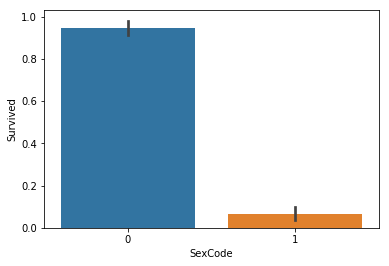

In [2025]:
sns.barplot(x = 'SexCode', y = 'Survived', data = testDataTemp)
plt.show()

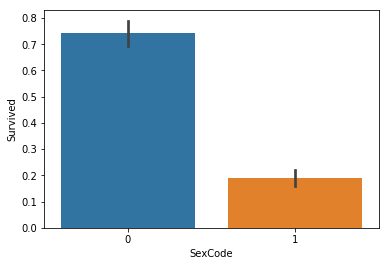

In [2026]:
sns.barplot(x = 'SexCode', y = 'Survived', data = trData)
plt.show()

In [2027]:
sum(trData['Survived'])

342

In [2028]:
len(trData['Survived'])

891

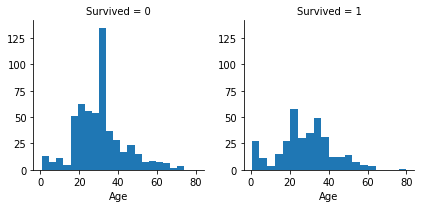

In [2029]:
import seaborn as sns
g = sns.FacetGrid(trData, col='Survived')
g.map(plt.hist, 'Age', bins=20)
plt.show()

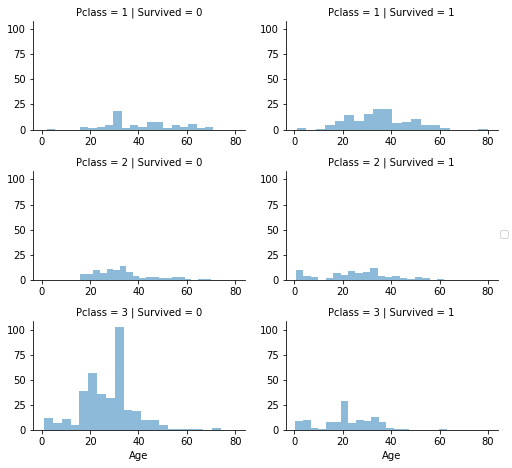

In [2030]:
grid = sns.FacetGrid(trData, col='Survived', row='Pclass', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();
plt.show()

In [2031]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()
vect.fit(trData['Name'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)